In [7]:
import tensorflow as tf

In [12]:
print(sys.executable)
print(sys.version)
print(sys.version_info)

print(tf.__version__)

/Users/peterverhaar/opt/anaconda3/bin/python
3.8.8 (default, Apr 13 2021, 12:59:45) 
[Clang 10.0.0 ]
sys.version_info(major=3, minor=8, micro=8, releaselevel='final', serial=0)
2.5.0


The code below fetches the cats vs. dogs dataset using TFDS. 

The `tf.keras.preprocessing.image_dataset_from_directory` can be used to generate similar labeled dataset objects from a set of images on disk filed into class-specific folders.



In [37]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'Image', labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(256,
    256), shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False, smart_resize=False
)


Found 595 files belonging to 2 classes.


In [36]:

ds_size = 595

train_split=0.8
val_split=0.1
test_split=0.1

train_size = int(train_split * ds_size)
val_size = int(val_split * ds_size)
    
train_ds = dataset.take(train_size)    
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size).skip(val_size)
    

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Number of training samples: 19
Number of validation samples: 3
Number of test samples: 0


TypeError: Invalid shape (32, 256, 256, 3) for image data

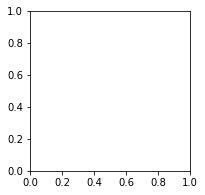

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

Resize images to 150x150

In [32]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

Batch the data and use caching & prefetching 
(What is this?)

In [33]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

Random data augmentation

In [34]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [35]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

InvalidArgumentError: Cannot batch tensors with different shapes in component 0. First element had shape [32,150,150,3] and element 18 had shape [19,150,150,3]. [Op:IteratorGetNext]

Build a model

In [ ]:
base_model = keras.applications.VGG16(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Train the top layer

In [20]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
112/291 [==========>...................] - ETA: 9:06 - loss: 0.2401 - binary_accuracy: 0.8862

KeyboardInterrupt: 